In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statistics import variance, median
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit

In [84]:
import json
import rich.progress

with rich.progress.open("data/data.json", "rb") as file:
    json_data = [json.loads(line) for line in file]

Output()

In [85]:
label_df = pd.read_csv("data/data.info")

In [86]:
all_rows = []

for list_index in tqdm(range(len(json_data))):
    #print(json_data[list_index])
    for gene_id in json_data[list_index]:
        for pos in json_data[list_index][gene_id]:
            for bases in json_data[list_index][gene_id][pos]:
                reads = json_data[list_index][gene_id][pos][bases]
                #avg_reads = [sum(x)/len(x) for x in zip(*reads)]
                median_reads = [median(x) for x in zip(*reads)]
                #variance_reads = [variance(x) for x in zip(*reads)]
                #first_qrt_reads = [np.percentile(x, 25) for x in zip(*reads)]
                #third_qrt_reads = [np.percentile(x, 75) for x in zip(*reads)]
                n_reads = [len(reads)]
                one_row = [gene_id, int(pos), bases] + median_reads + n_reads
                all_rows.append(one_row)

100%|██████████| 121838/121838 [00:20<00:00, 6088.06it/s]


In [87]:
df = pd.DataFrame(all_rows, columns =['transcript_id', 'transcript_position', 'bases', 
'Prev_Pos_median_of_DT', 'Prev_Pos_median_of_SD', 'Prev_Pos_median_of_Mean', 
'Curr_Pos_median_of_DT', 'Curr_Pos_median_of_SD', 'Curr_Pos_median_of_Mean',
'Next_Pos_median_of_DT', 'Next_Pos_median_of_SD', 'Next_Pos_median_of_Mean',

#'Prev_Pos_median_of_DT', 'Prev_Pos_median_of_SD', 'Prev_Pos_median_of_Mean', 
#'Curr_Pos_median_of_DT', 'Curr_Pos_median_of_SD', 'Curr_Pos_median_of_Mean',
#'Next_Pos_median_of_DT', 'Next_Pos_median_of_SD', 'Next_Pos_median_of_Mean',


#'Prev_Pos_sd_of_DT', 'Prev_Pos_sd_of_SD', 'Prev_Pos_sd_of_Mean', 
#'Curr_Pos_sd_of_DT', 'Curr_Pos_sd_of_SD', 'Curr_Pos_sd_of_Mean',
#'Next_Pos_sd_of_DT', 'Next_Pos_sd_of_SD', 'Next_Pos_sd_of_Mean', 

#'Prev_Pos_first_qrt_of_DT', 'Prev_Pos_first_qrt_of_SD', 'Prev_Pos_first_qrt_of_Mean', 
#'Curr_Pos_first_qrt_of_DT', 'Curr_Pos_first_qrt_of_SD', 'Curr_Pos_first_qrt_of_Mean',
#'Next_Pos_first_qrt_of_DT', 'Next_Pos_first_qrt_of_SD', 'Next_Pos_first_qrt_of_Mean',

#'Prev_Pos_third_qrt_of_DT', 'Prev_Pos_third_qrt_of_SD', 'Prev_Pos_third_qrt_of_Mean', 
#'Curr_Pos_third_qrt_of_DT', 'Curr_Pos_third_qrt_of_SD', 'Curr_Pos_third_qrt_of_Mean',
#'Next_Pos_third_qrt_of_DT', 'Next_Pos_third_qrt_of_SD', 'Next_Pos_third_qrt_of_Mean',

'n_reads'])

df = df.merge(label_df, how = 'left', on = ['transcript_id', 'transcript_position'])

In [88]:
df["left_1"] = df["bases"].apply(lambda x: x[0])
df["curr_pos_bases"] = df["bases"].apply(lambda x: x[1:6])
df["right_5"] = df["bases"].apply(lambda x: x[6])

In [89]:
df["centre_1"] = df["curr_pos_bases"].apply(lambda x: x[0])
df["centre_2"] = df["curr_pos_bases"].apply(lambda x: x[1])
df["centre_3"] = df["curr_pos_bases"].apply(lambda x: x[2])
df["centre_4"] = df["curr_pos_bases"].apply(lambda x: x[3])
df["centre_5"] = df["curr_pos_bases"].apply(lambda x: x[4])

In [90]:
df["A_count"] = df["bases"].apply(lambda x: x.count('A'))
df["G_count"] = df["bases"].apply(lambda x: x.count('G'))
df["C_count"] = df["bases"].apply(lambda x: x.count('C'))
df["T_count"] = df["bases"].apply(lambda x: x.count('T'))

In [92]:
categorical_cols = ['left_1', 'centre_1', 'centre_2', 'centre_3', 'centre_4', 'centre_5', 'right_5']


df = pd.get_dummies(df, columns = categorical_cols)

In [94]:
df.columns

Index(['transcript_id', 'transcript_position', 'bases',
       'Prev_Pos_median_of_DT', 'Prev_Pos_median_of_SD',
       'Prev_Pos_median_of_Mean', 'Curr_Pos_median_of_DT',
       'Curr_Pos_median_of_SD', 'Curr_Pos_median_of_Mean',
       'Next_Pos_median_of_DT', 'Next_Pos_median_of_SD',
       'Next_Pos_median_of_Mean', 'n_reads', 'gene_id', 'label',
       'curr_pos_bases', 'A_count', 'G_count', 'C_count', 'T_count',
       'left_1_A', 'left_1_C', 'left_1_G', 'left_1_T', 'centre_1_A',
       'centre_1_G', 'centre_1_T', 'centre_2_A', 'centre_2_G', 'centre_3_A',
       'centre_4_C', 'centre_5_A', 'centre_5_C', 'centre_5_T', 'right_5_A',
       'right_5_C', 'right_5_G', 'right_5_T'],
      dtype='object')

In [95]:
expected_columns = ['left_1_A', 'left_1_C', 'left_1_G', 'left_1_T',
                    'centre_1_A', 'centre_1_G', 'centre_1_T', 
                    'centre_2_A', 'centre_2_G', 
                    #'centre_3_A',
                    #'centre_4_C',
                    'centre_5_A', 'centre_5_C', 'centre_5_T',
                    'right_5_A', 'right_5_C', 'right_5_G', 'right_5_T']

In [96]:
added_cols = []
df_cols = df.columns
for col in expected_columns:
    if col not in df_cols:
        df[col] = [0 for i in range(len(df))]
        added_cols.append(col)

In [97]:
ordered_columns = ['transcript_id', 'transcript_position', 'bases', 'gene_id', 
       'Prev_Pos_median_of_DT', 'Prev_Pos_median_of_SD', 'Prev_Pos_median_of_Mean', 
       'Curr_Pos_median_of_DT', 'Curr_Pos_median_of_SD', 'Curr_Pos_median_of_Mean',
       'Next_Pos_median_of_DT', 'Next_Pos_median_of_SD', 'Next_Pos_median_of_Mean',

       #'Prev_Pos_median_of_DT', 'Prev_Pos_median_of_SD', 'Prev_Pos_median_of_Mean', 
       #'Curr_Pos_median_of_DT', 'Curr_Pos_median_of_SD', 'Curr_Pos_median_of_Mean',
       #'Next_Pos_median_of_DT', 'Next_Pos_median_of_SD', 'Next_Pos_median_of_Mean',

       #'Prev_Pos_sd_of_DT', 'Prev_Pos_sd_of_SD', 'Prev_Pos_sd_of_Mean', 
       #'Curr_Pos_sd_of_DT', 'Curr_Pos_sd_of_SD', 'Curr_Pos_sd_of_Mean',
       #'Next_Pos_sd_of_DT', 'Next_Pos_sd_of_SD', 'Next_Pos_sd_of_Mean', 
       
       #'Prev_Pos_first_qrt_of_DT', 'Prev_Pos_first_qrt_of_SD', 'Prev_Pos_first_qrt_of_Mean', 
       #'Curr_Pos_first_qrt_of_DT', 'Curr_Pos_first_qrt_of_SD', 'Curr_Pos_first_qrt_of_Mean',
       #'Next_Pos_first_qrt_of_DT', 'Next_Pos_first_qrt_of_SD', 'Next_Pos_first_qrt_of_Mean',

       #'Prev_Pos_third_qrt_of_DT', 'Prev_Pos_third_qrt_of_SD', 'Prev_Pos_third_qrt_of_Mean', 
       #'Curr_Pos_third_qrt_of_DT', 'Curr_Pos_third_qrt_of_SD', 'Curr_Pos_third_qrt_of_Mean',
       #'Next_Pos_third_qrt_of_DT', 'Next_Pos_third_qrt_of_SD', 'Next_Pos_third_qrt_of_Mean',

       'n_reads', 'A_count', 'G_count', 'C_count', 'T_count',
       'left_1_A', 'left_1_C', 'left_1_G', 'left_1_T',
       'centre_1_A', 'centre_1_G', 'centre_1_T', 
       'centre_2_A', 'centre_2_G', 
       'centre_5_A', 'centre_5_C', 'centre_5_T',
       'right_5_A', 'right_5_C', 'right_5_G', 'right_5_T', 'label']

In [99]:
df = df[ordered_columns]
df2 = df.drop(['transcript_id', 'bases'], axis = 1)
df2["id"] = df2.index
gene_ids = list(df2["gene_id"].unique())

In [100]:
train_ids, test_ids = train_test_split(gene_ids, train_size = 0.8)
tuning_train_ids, tuning_val_ids = train_test_split(train_ids, train_size = 0.7)

In [101]:
train_df = df2[df2["gene_id"].isin(train_ids)]
val_df = df2[df2["gene_id"].isin(tuning_val_ids)]
test_df = df2[df2["gene_id"].isin(test_ids)]

In [102]:
split_index = [-1 if x in val_df.id else 0 for x in train_df.id]
pds = PredefinedSplit(test_fold = split_index)
train_df = train_df.drop(["id"], axis = 1)
val_df = val_df.drop(["id"], axis = 1)
test_df = test_df.drop(["id"], axis = 1)

In [103]:
X_train = train_df.drop(["gene_id", "label"], axis = 1).to_numpy()
y_train = train_df[["label"]].to_numpy().ravel()

X_val = val_df.drop(["gene_id", "label"], axis = 1).to_numpy()
y_val = val_df[["label"]].to_numpy().ravel()


X_test = test_df.drop(["gene_id", "label"], axis = 1).to_numpy()
y_test = test_df[["label"]].to_numpy().ravel()

In [113]:
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_val))
print(np.shape(y_val))
print(np.shape(X_test))
print(np.shape(y_test))

(98070, 31)
(98070,)
(29055, 31)
(29055,)
(23768, 31)
(23768,)


In [104]:
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree'],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 0.8],
    'scale_pos_weight': [5,7,14]
}

In [105]:
from sklearn.metrics import precision_recall_curve, make_scorer, auc, roc_auc_score, average_precision_score

def pr_auc_roc_auc_mean_score(y_true, y_prob):
    """
    Generates the Area Under the Curve for precision and recall.
    """
    #precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    roc_auc = roc_auc_score(y_true, y_prob)
    #pr_auc = auc(recall, precision)
    pr_auc = average_precision_score(y_true, y_prob)
    return (roc_auc + pr_auc)/2

# P: TP/(TP+FP)
# R: TP/(TP+FN)
# 

pr_auc_roc_auc_mean_scorer = make_scorer(pr_auc_roc_auc_mean_score, greater_is_better=True,
                            needs_proba=True)

In [106]:
tuning_model = RandomizedSearchCV(XGBClassifier(), params, n_jobs=-1, cv=pds, scoring=pr_auc_roc_auc_mean_scorer, n_iter = 100) #'average_precision'
tuning_model.fit(X_train, y_train)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction...
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'base_score': [0.2, 0.5, 0.8],
                                        'booster': ['gbtree'],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'n_estimators': [100, 200, 500],
                                        'reg_alpha': [0, 0.5, 1],
                                        'reg_lambda': [0.5, 1, 5],
                                        'scale_pos_weight': [5, 7, 14]},
                   scoring=make_scorer(pr_auc_roc_auc_mean_score, needs_proba=True))

In [107]:
(pd.DataFrame(tuning_model.cv_results_)).sort_values(by=['rank_test_score']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scale_pos_weight,param_reg_lambda,param_reg_alpha,param_n_estimators,param_learning_rate,param_booster,param_base_score,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
69,24.005186,0.0,0.704703,0.0,5,1,1,200,0.05,gbtree,0.8,"{'scale_pos_weight': 5, 'reg_lambda': 1, 'reg_...",0.646142,0.646142,0.0,1
0,23.929969,0.0,1.074891,0.0,5,1,0.5,200,0.05,gbtree,0.8,"{'scale_pos_weight': 5, 'reg_lambda': 1, 'reg_...",0.645774,0.645774,0.0,2
76,12.767277,0.0,0.445457,0.0,5,1,1,100,0.1,gbtree,0.8,"{'scale_pos_weight': 5, 'reg_lambda': 1, 'reg_...",0.644943,0.644943,0.0,3
36,24.202205,0.0,0.744769,0.0,7,0.5,1,200,0.05,gbtree,0.8,"{'scale_pos_weight': 7, 'reg_lambda': 0.5, 're...",0.644785,0.644785,0.0,4
53,12.028321,0.0,0.411888,0.0,7,5,1,100,0.1,gbtree,0.2,"{'scale_pos_weight': 7, 'reg_lambda': 5, 'reg_...",0.644289,0.644289,0.0,5


In [108]:
tuning_model.best_params_

{'scale_pos_weight': 5,
 'reg_lambda': 1,
 'reg_alpha': 1,
 'n_estimators': 200,
 'learning_rate': 0.05,
 'booster': 'gbtree',
 'base_score': 0.8}

In [109]:
model = XGBClassifier(scale_pos_weight=5, reg_lambda= 1, reg_alpha= 1, n_estimators= 200,learning_rate= 0.05,booster= 'gbtree',base_score= 0.8)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.8, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=1, reg_lambda=1, ...)

In [67]:
# hyperparams : XGBClassifier(scale_pos_weight=5, reg_lambda= 5, reg_alpha= 0.5, n_estimators= 100,learning_rate= 0.05,booster= 'gbtree',base_score= 0.5) #WITH roc-auc

y_pred=model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_proba))
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
print(auc(precision,recall))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     21905
           1       0.49      0.49      0.49      1075

    accuracy                           0.95     22980
   macro avg       0.73      0.73      0.73     22980
weighted avg       0.95      0.95      0.95     22980

0.901568591645743
0.45809448286520577


In [77]:
# hyperparams: XGBClassifier(scale_pos_weight=5, reg_lambda= 0.5, reg_alpha= 1, n_estimators= 200,learning_rate= 0.05,booster= 'gbtree',base_score= 0.8) #only average_precision_score as metric
y_pred=model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_proba))
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
print(auc(precision,recall))
### BEST MODELLLLL

y_pred=model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_proba))
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
print(auc(precision,recall))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     21905
           1       0.50      0.51      0.51      1075

    accuracy                           0.95     22980
   macro avg       0.74      0.74      0.74     22980
weighted avg       0.95      0.95      0.95     22980

0.902966573416922
0.4706846009873644
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     29096
           1       0.57      0.61      0.59      1397

    accuracy                           0.96     30493
   macro avg       0.78      0.79      0.78     30493
weighted avg       0.96      0.96      0.96     30493

0.9522603967534028
0.5522313609427854


In [73]:
# hyperparams: XGBClassifier(scale_pos_weight=5, reg_lambda= 5, reg_alpha= 0, n_estimators= 100,learning_rate= 0.1,booster= 'gbtree',base_score= 0.8) #with both metrics
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_proba))
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
print(auc(precision,recall))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     21905
           1       0.50      0.51      0.51      1075

    accuracy                           0.95     22980
   macro avg       0.74      0.74      0.74     22980
weighted avg       0.95      0.95      0.95     22980

0.901568591645743
0.4706846009873644


In [114]:
# XGBClassifier(scale_pos_weight=5, reg_lambda= 1, reg_alpha= 1, n_estimators= 200,learning_rate= 0.05,booster= 'gbtree',base_score= 0.8) #added A_count, G_count, C_count, T_count
y_pred=model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_proba))
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
print(auc(precision,recall))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     22769
           1       0.47      0.53      0.50       999

    accuracy                           0.96     23768
   macro avg       0.72      0.75      0.74     23768
weighted avg       0.96      0.96      0.96     23768

0.8904738327857481
0.46579426770074706


In [39]:
# hyperparams: XGBClassifier(reg_lambda= 1, reg_alpha= 0.5, n_estimators= 100,learning_rate= 0.1,booster= 'gbtree',base_score= 0.8, scale_pos_weight=5) (auc, no SDS)
y_pred=model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     23154
           1       0.49      0.53      0.51      1151

    accuracy                           0.95     24305
   macro avg       0.73      0.75      0.74     24305
weighted avg       0.95      0.95      0.95     24305



# EDA

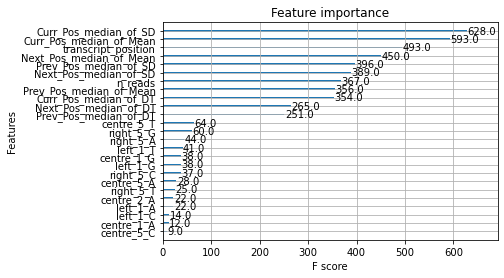

In [76]:
from xgboost import plot_importance
from matplotlib import pyplot
model.get_booster().feature_names = list(train_df.drop(["gene_id", "label"], axis = 1).columns)
plot_importance(model)
pyplot.show()

In [75]:
train_df.columns

Index(['transcript_position', 'gene_id', 'Prev_Pos_median_of_DT',
       'Prev_Pos_median_of_SD', 'Prev_Pos_median_of_Mean',
       'Curr_Pos_median_of_DT', 'Curr_Pos_median_of_SD',
       'Curr_Pos_median_of_Mean', 'Next_Pos_median_of_DT',
       'Next_Pos_median_of_SD', 'Next_Pos_median_of_Mean', 'n_reads',
       'left_1_A', 'left_1_C', 'left_1_G', 'left_1_T', 'centre_1_A',
       'centre_1_G', 'centre_1_T', 'centre_2_A', 'centre_2_G', 'centre_5_A',
       'centre_5_C', 'centre_5_T', 'right_5_A', 'right_5_C', 'right_5_G',
       'right_5_T', 'label'],
      dtype='object')